# Разведочный анализ данных – Exploratory Data Analysis (EDA)
О датасете
Этот набор данных содержит подробные записи данных смоделированных дорожно-транспортных происшествий, уделяя особое внимание факторам, влияющим на результаты выживания. Набор данных включает демографические, поведенческие и ситуационные атрибуты, предоставляя ценную информацию о том, как различные факторы влияют на вероятность выживания во время дорожно-транспортных происшествий.
## Описание датасета
* Age возраст водителя
* Gender пол (Female/Male)
* Speed_of_Impact скорость перед столкновением (mph)
* Helmet_Used использован шлем или нет (No/Yes)
* Seatbelt_Used водитель был пристегнут или нет (No/Yes)
* Survived (0 - не выжил, 1 - выжил)
  

Необходимо решить задачу классификации и научиться предсказывать целовой признак Survived or not выживет ли пассажир по его нецелевым признакам.

Сперва подключим необходимые библиотеки.



In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Считываем обучающую выборку.

In [150]:
df = pd.read_csv('/kaggle/input/road-accident-survival-dataset/accident.csv')

In [151]:
df.head()

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
0,56,Female,27.0,No,No,1
1,69,Female,46.0,No,Yes,1
2,46,Male,46.0,Yes,Yes,0
3,32,Male,117.0,No,Yes,0
4,60,Female,40.0,Yes,Yes,0


Проверяем общее количество пропущенных значений.



In [152]:
df.isnull().sum()

Age                0
Gender             1
Speed_of_Impact    3
Helmet_Used        0
Seatbelt_Used      0
Survived           0
dtype: int64

Признаки Gender и Speed_of_Impact имеют пропущенные значения. Будем это учитывать в дальнейшем при очистке данных.

# Первичный анализ признаков
## Категориальный признак Gender

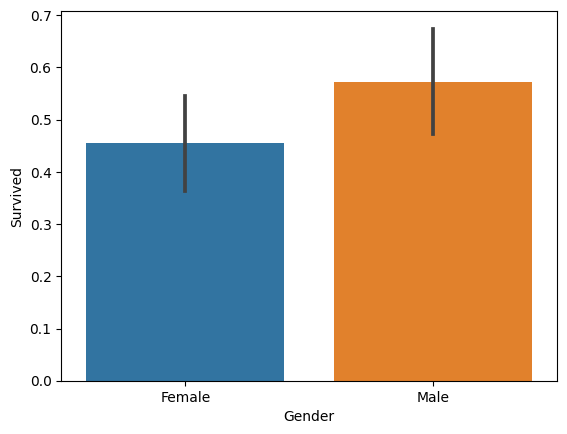

In [153]:
sns.barplot(x = "Gender", y = "Survived", data = df);

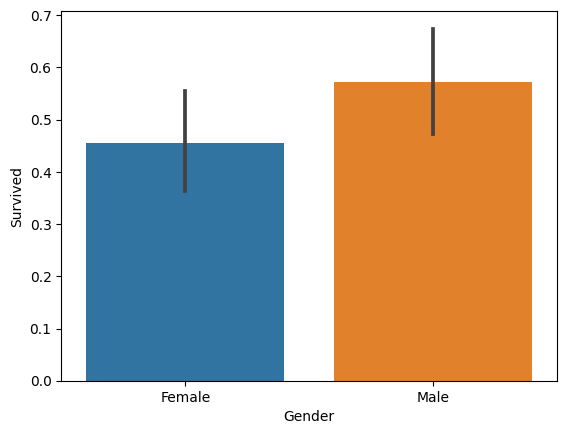

In [154]:
sns.barplot(x = "Gender", y = "Survived", data = df);

Выжило около 45% женщин и около 56% мужчин.
Признак Gender кажется очень важным для этой задачи и имеющим сильную зависимость с целевым признаком. Проанализируем другие признаки.


## Категориальный признак Seatbelt_Used

In [155]:
df.groupby(['Seatbelt_Used', 'Survived'])['Survived'].count()  # оба признака категориальные, группируем и считаем колличество


Seatbelt_Used  Survived
No             0           47
               1           42
Yes            0           52
               1           59
Name: Survived, dtype: int64

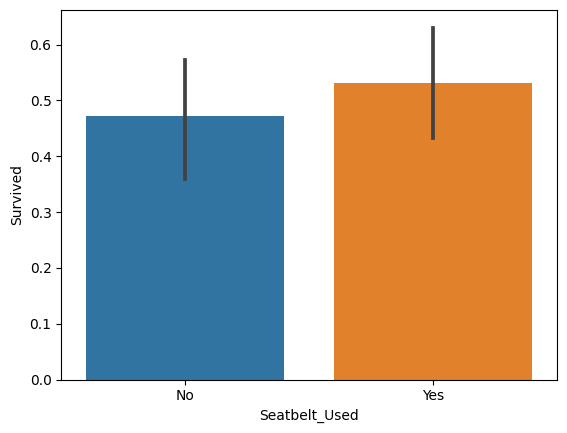

In [156]:
sns.barplot(x = "Seatbelt_Used", y = "Survived", data = df);

Ремень безопасности тоже влияет на выживаемость.

## Категориальный признак Helmet_Used

In [157]:
df.groupby(['Helmet_Used', 'Survived'])['Survived'].count()  # оба признака категориальные, группируем и считаем колличество

Helmet_Used  Survived
No           0           42
             1           47
Yes          0           57
             1           54
Name: Survived, dtype: int64

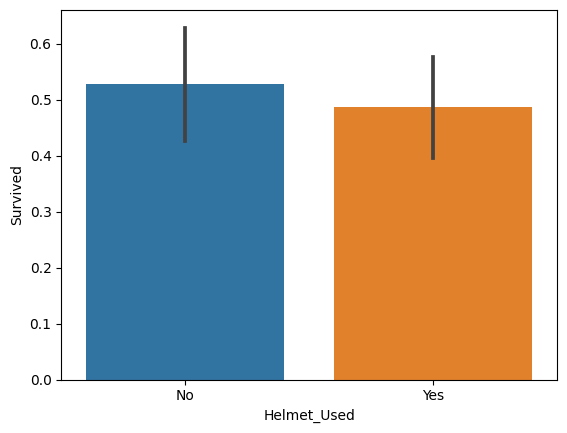

In [158]:
sns.barplot(x = "Helmet_Used", y = "Survived", data = df);


Контринтуитивная зависимость.

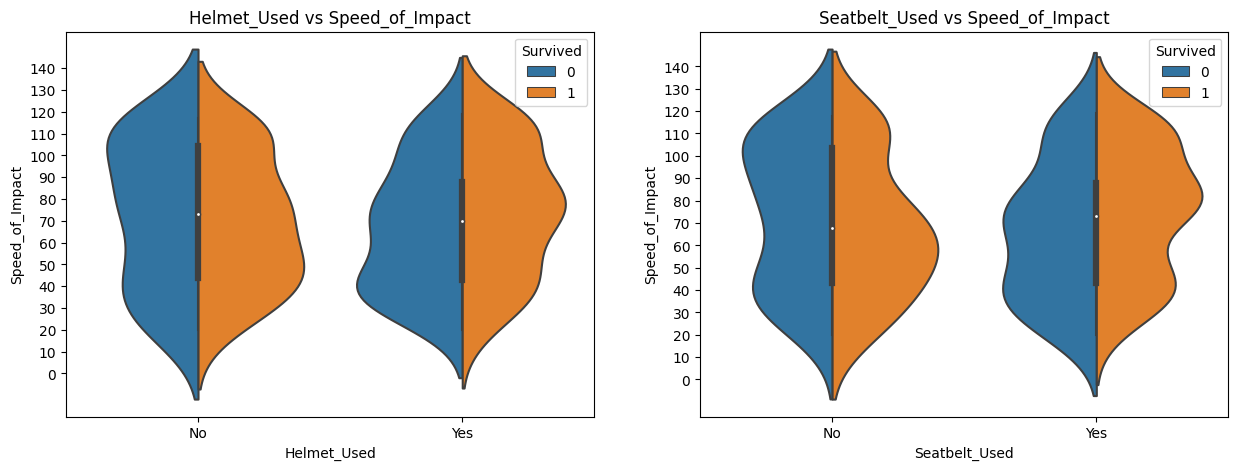

In [159]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.violinplot(x="Helmet_Used", y="Speed_of_Impact", hue="Survived", data=df, split=True, ax=ax[0])
ax[0].set_title('Helmet_Used vs Speed_of_Impact')
ax[0].set_yticks(range(0, 150, 10))
sns.violinplot(x="Seatbelt_Used", y="Speed_of_Impact", hue="Survived", data=df, split=True, ax=ax[1])
ax[1].set_title('Seatbelt_Used vs Speed_of_Impact')
ax[1].set_yticks(range(0, 150, 10))
plt.show()

* Без шлема шанс выжить больше, если скорость ниже 70
* Со шлемом - если скорость ближе к 70
* Пристегнутый ремень спасает чаще на скорости близкой к 70
* Без пристегнутого ремня шанс выжить больше при меньей скорости

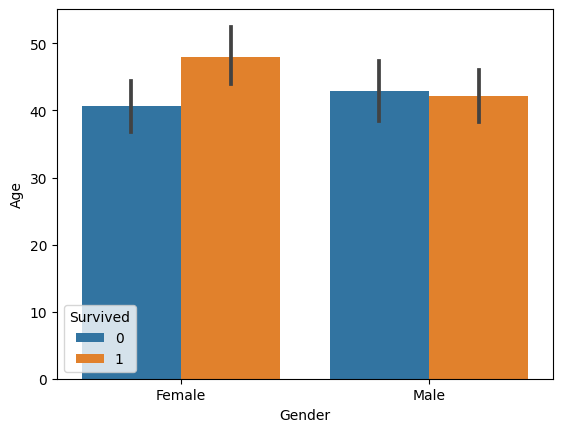

In [160]:
sns.barplot(x = "Gender", y = "Age", hue="Survived", data = df);


* У женщины шанс выжить больше, если она старше

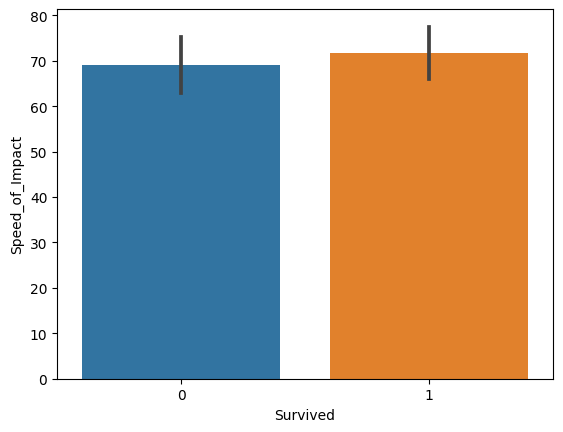

In [161]:
sns.barplot(x = "Survived", y = "Speed_of_Impact", data = df);

## Data Cleaning
У нас есть 1 пропущенное значение у Gender и 3 пропущенных значения у Speed_of_Impact.
Для восстановления Gender возьмем наиболее вероятный признак

In [162]:
df['Gender'].describe()

count        199
unique         2
top       Female
freq         110
Name: Gender, dtype: object

Заполняем пропущенное значение Female

In [163]:
df.loc[(df['Gender'].isnull()), 'Gender'] = "Female"
df['Gender'].isnull().any() #проверка

False

Пропущенные значения у Speed_of_Impact

In [164]:
df.loc[df['Speed_of_Impact'].isnull() == True]

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
15,41,Female,NaN,No,No,0
19,41,Male,NaN,Yes,No,1
29,42,Male,NaN,Yes,No,0


Определяем по известным аналитическим данным

15 строка\
без шлема, не выжила => вероятннее скорость 105 или 40\
не пристегнута, не выжила => 105 или 40\
вариант со скоростью 105 более вероятен в обоих случаях (исходя из данных violinplot'а), поэтому выбираем его

19 строка\
со шлемом, выжил => вероятннее скорость 80\
не пристегнут, выжил => вероятннее скорость 60\
берем среднее значение - 70

29 строка\
со шлемом, не выжил => вероятннее скорость 40\
не пристегнут, не выжил => вероятннее скорость 105 или 40\
40 встречается 2 раза - берем 40
* 15 строка: 105
* 19 строка: 70
* 29 строка: 40

In [165]:
df.loc[15, 'Speed_of_Impact'] = 105
df.loc[19, 'Speed_of_Impact'] = 70
df.loc[29, 'Speed_of_Impact'] = 40
df['Gender'].isnull().any() #проверка

False

In [166]:
df.isnull().sum()

Age                0
Gender             0
Speed_of_Impact    0
Helmet_Used        0
Seatbelt_Used      0
Survived           0
dtype: int64

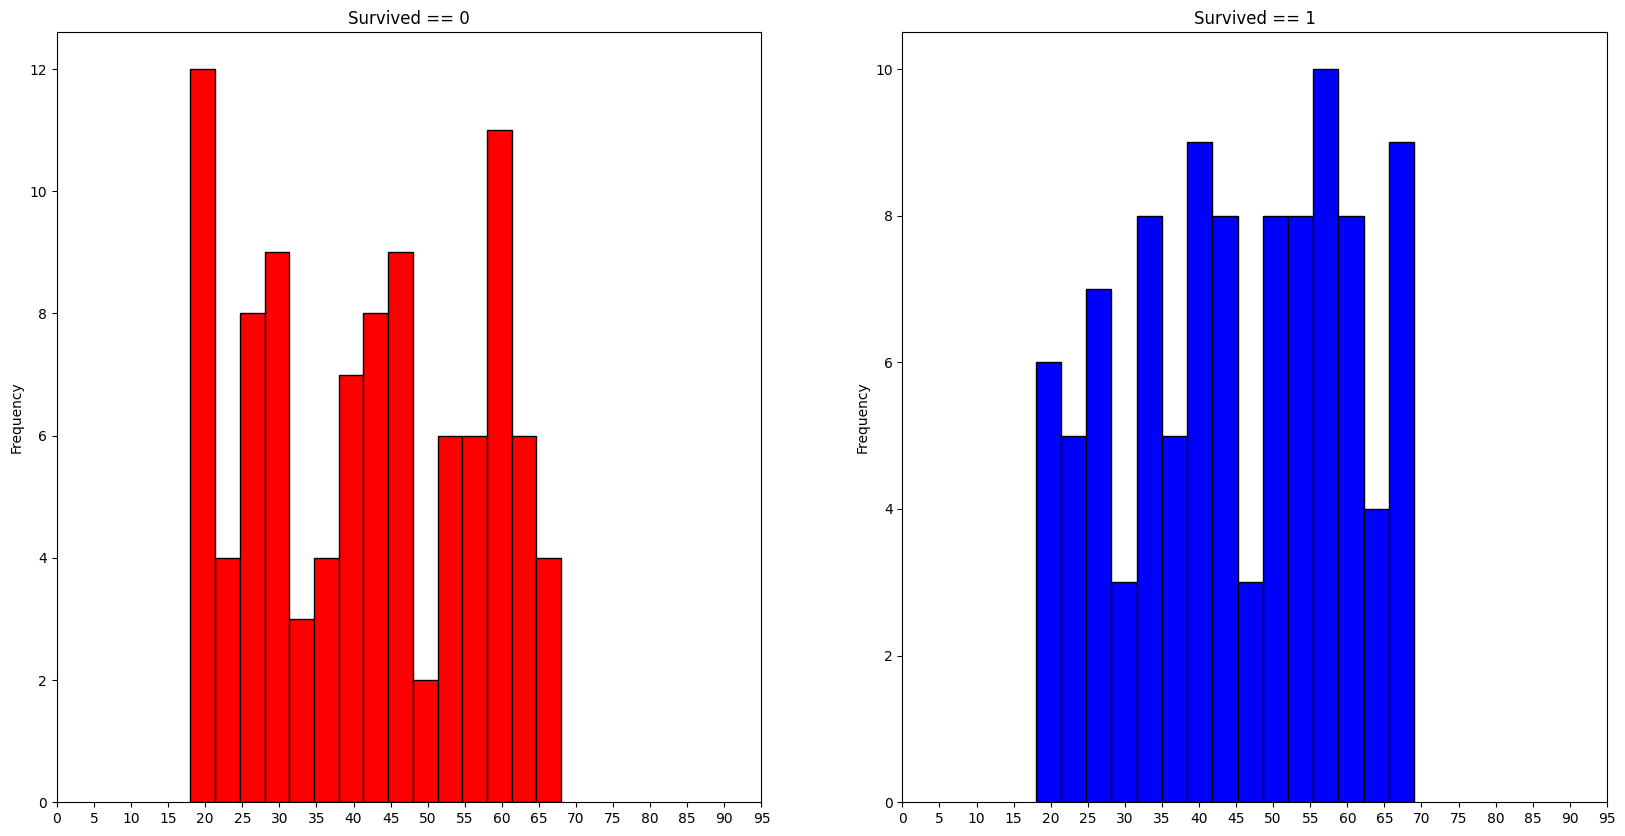

In [167]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
df[df['Survived'] == 0]['Age'].plot.hist(ax=ax[0], edgecolor='black', color='red', bins=15)
ax[0].set_title('Survived == 0')
x1 = list(range(0, 100, 5))
ax[0].set_xticks(x1)
df[df['Survived'] == 1].Age.plot.hist(ax=ax[1],color='blue',edgecolor='black', bins=15)
ax[1].set_title('Survived == 1')
x2 = list(range(0, 100, 5))
ax[1].set_xticks(x2)
plt.show()

* Больше всего погибло молодых людей около 20 лет

## Выводы:
* **Age:** У женщины шанс выжить больше, если она старше
* **Gender:** Мужчины выживают чаще, чем женщины
* **Speed_of_Impact:** 40-75 - самая безопасная скорость
* **Helmet_Used:**\
  Без шлема шанс выжить больше, если скорость ниже 70\
  Со шлемом - если скорость ближе к 70
* **Seatbelt_Used:**\
  Пристегнутый ремень спасает чаще на скорости близкой к 70\
  Без пристегнутого ремня шанс выжить больше при меньей скорости\
* **Survived:** Больше всего погибло молодых людей около 20 лет, в шлеме люди чаще погибают на скорости около 40 м/с. С пристегнутым ремнем безопасности шанс выжить больше

# Feature Engineering

## Трансформация строк в числа



In [168]:
df['Gender'].replace(['Female', 'Male'], [0, 1], inplace=True)
df['Helmet_Used'].replace(['No', 'Yes'], [0, 1], inplace=True)
df['Seatbelt_Used'].replace(['No', 'Yes'], [0, 1], inplace=True)
df['Age'].describe()

count    200.00000
mean      43.42500
std       14.94191
min       18.00000
25%       31.00000
50%       43.50000
75%       56.00000
max       69.00000
Name: Age, dtype: float64

## Новый признак возрастные категории Age_category
Воспользуемся признаком Age и выделим во множестве его значений (от 18 до 69) категории (интервалы).

In [169]:
df['Age_category'] = 0  # заполняем сначала значения нового признака нулями
df.loc[df['Age'] <= 21, 'Age_category'] = 0  # далле разбиваем возраста на 5 категорий
df.loc[(df['Age'] > 21) & (df['Age'] <= 33), 'Age_category'] = 1
df.loc[(df['Age'] > 33) & (df['Age'] <= 48), 'Age_category'] = 2
df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age_category'] = 3
df.loc[df['Age'] > 64, 'Age_category'] = 4
df.head()

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived,Age_category
0,56,0,27.0,0,0,1,3
1,69,0,46.0,0,1,1,4
2,46,1,46.0,1,1,0,2
3,32,1,117.0,0,1,0,1
4,60,0,40.0,1,1,0,3


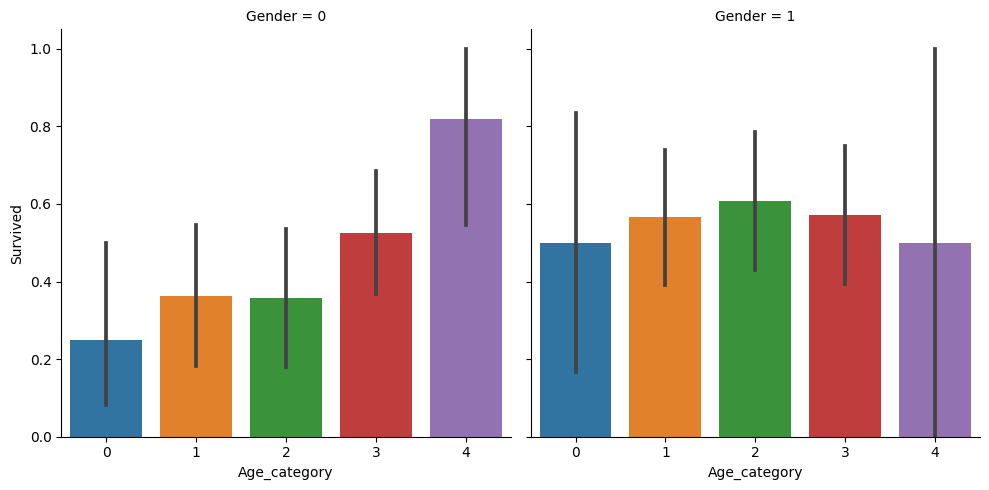

In [170]:
sns.catplot(x='Age_category', y='Survived', data = df, col = 'Gender', kind='bar')
plt.show()

Как уже говорилось, у женщин выживаемость зависит от возраста

## Новый признак защищенность Safety

In [171]:
df['Safety'] = 0  # заполняем сначала значения нового признака нулями
df.loc[(df['Seatbelt_Used'] == 0) & (df['Helmet_Used'] == 0), 'Safety'] = 0  # далле разбиваем возраста на 5 категорий
df.loc[(df['Seatbelt_Used'] == 0) & (df['Helmet_Used'] == 1), 'Safety'] = 1
df.loc[(df['Seatbelt_Used'] == 1) & (df['Helmet_Used'] == 0), 'Safety'] = 1
df.loc[(df['Seatbelt_Used'] == 1) & (df['Helmet_Used'] == 1), 'Safety'] = 2
df.head()

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived,Age_category,Safety
0,56,0,27.0,0,0,1,3,0
1,69,0,46.0,0,1,1,4,1
2,46,1,46.0,1,1,0,2,2
3,32,1,117.0,0,1,0,1,1
4,60,0,40.0,1,1,0,3,2


## Новый признак диапазоны скорости Speed_category


In [172]:
df['Speed_of_Impact'].describe()

count    200.000000
mean      70.460000
std       30.075089
min       20.000000
25%       43.000000
50%       71.000000
75%       95.500000
max      119.000000
Name: Speed_of_Impact, dtype: float64

In [173]:
df['Speed_category'] = 0  # заполняем сначала значения нового признака нулями
df.loc[(df['Speed_of_Impact'] > 0) & (df['Speed_of_Impact'] <= 37), 'Speed_category'] = 0  # далле разбиваем возраста на 6 категорий
df.loc[(df['Speed_of_Impact'] > 37) & (df['Speed_of_Impact'] <= 50), 'Speed_category'] = 1
df.loc[(df['Speed_of_Impact'] > 50) & (df['Speed_of_Impact'] <= 62), 'Speed_category'] = 2
df.loc[(df['Speed_of_Impact'] > 62) & (df['Speed_of_Impact'] <= 75), 'Speed_category'] = 3
df.loc[(df['Speed_of_Impact'] > 75) & (df['Speed_of_Impact'] <= 95), 'Speed_category'] = 4
df.loc[(df['Speed_of_Impact'] > 95) & (df['Speed_of_Impact'] <= 120), 'Speed_category'] = 5
df.head()

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived,Age_category,Safety,Speed_category
0,56,0,27.0,0,0,1,3,0,0
1,69,0,46.0,0,1,1,4,1,1
2,46,1,46.0,1,1,0,2,2,1
3,32,1,117.0,0,1,0,1,1,5
4,60,0,40.0,1,1,0,3,2,1


## Корреляция признаков

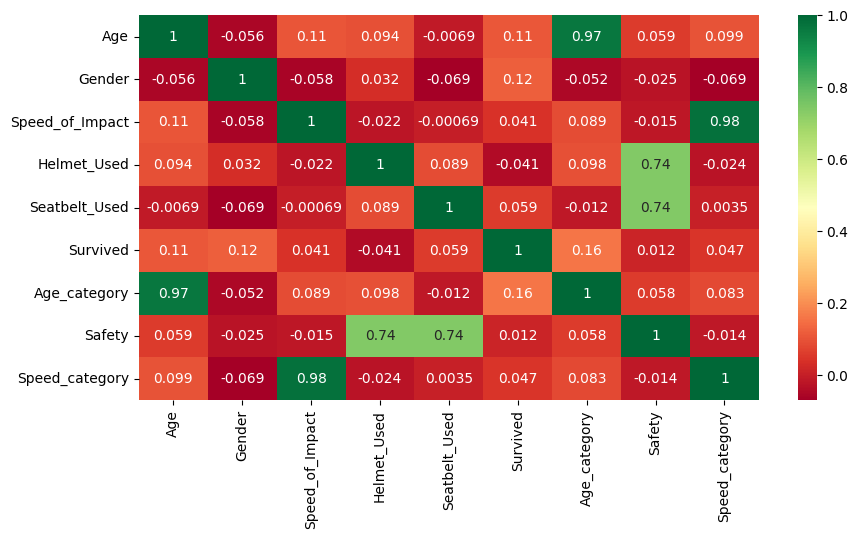

In [174]:
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(data=numeric_df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Заметим интересный факт, что использование ремня безопасности, можно сказать, не коррелирует со скоростью во время столкновения и возрастом

## Удаление ненужных признаков
* Age –– вместо него будем использовать категории возрастов Age_category
* Speed_of_Impact меняем на Speed_category
* Helmet_Used и Seatbelt_Used - заменяем на Safety

In [175]:
df.drop(['Age', 'Helmet_Used', 'Seatbelt_Used', 'Speed_of_Impact'], axis=1, inplace=True)
df.head()

,Gender,Survived,Age_category,Safety,Speed_category
0,0,1,3,0,0
1,0,1,4,1,1
2,1,0,2,2,1
3,1,0,1,1,5
4,0,0,3,2,1


## Корреляция признаков


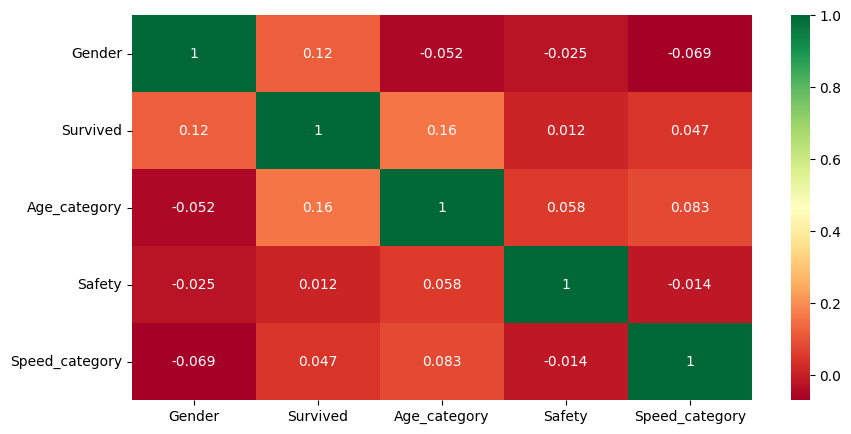

In [176]:
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(data=numeric_df.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

Можно сказать что имеющиеся признаки почти не коррелируют друг с другом.